# Taller de Física Computacional

Carlos Ruestes / Cristián Sánchez - Taller de Física Computacional - FCEN - UNCUYO

# Sesión 9: Rotación de un cuerpo rígido

## Ecuaciones de movimiento del sólido rígido en un marco inercial de referencia

Las simplificaciones que ofrecen las ecuaciones de Euler prmiten encontrar soluciones ciertos problemas de rotaciones de forma simple. Sin embargo, no nos permiten estudiar de manera completa el problema ya que sólo nos brindan información sobre la velocidad angular. Una pista de sus limitaciones es que son ecuaciones de movimiento de primer orden en el tiempo, son ecuaciones de movimiento para velocidades. La información completa sobre el movimiento del sólido debe provenir de ecuaciones de movimiento de segundo órden. Hay muchas formas de escribir las ecuaciones de movimiento completas, de hecho este problema sigue siento un tema de investigación hasta el día de hoy. 

Para construir un conjunto de ecuaciones capaz de describir el movimiento de un sólido desde el marco de referencia del sistema de coordenadas de laboratorio comenzamos por la ecuación de movimiento del momento angular:

$$ \frac{d\mathbf{L}}{dt}=\boldsymbol\tau $$

Si integramos esta ecuación tendremos el momento angular para todo tiempo. Luego, teniendo en cuenta que:

$$ \mathbf{L}=\mathbf{I}\boldsymbol\omega$$

podemos obtener el vector momento angular a partir de la inversión de la matriz que representa el tensor de inercia:

$$ \boldsymbol\omega = \mathbf{I}^{-1} \mathbf{L} $$

La integración del movimiento angular es posible, entre otras, describiendo la ecuación de movimiento para la matriz de rotación de la transformación de coordenadas $R$ entre el sistema de coordenadas fijo en el cuerpo y el sistema de laboratorio:

$$ \dot{R} = \boldsymbol\omega^* R $$

donde $\boldsymbol\omega^*$ es una matriz función de la velocidad angular que tiene la siguiente forma:

$$ \boldsymbol\omega^* = 
\begin{bmatrix}
    0 & -\omega_z & \omega_y \\
    \omega_z & 0 & \omega_x  \\
    -\omega_y & -\omega_x & 0 
\end{bmatrix} 
$$

Esta representación permite obtener cualquier producto de la forma $\boldsymbol\omega\times$ en forma matricial. 

De hecho, la ecuación de movimiento para $R$ puede obtenerse teniendo en cuenta que la matriz de transformación contiene como columna los versores del sistema rotado $\hat{e}_1,\hat{e}_2$ y $\hat{e}_3$ y que la ecuación de movimiento de cada uno de ellos es

$$
\frac{d \hat{e}_1}{dt} = \boldsymbol\omega\times\hat{e}_1
$$

Se debe tener en cuenta que $\mathbf{I}$ es una función del tiempo. El momento de inercia a todo tiempo puede obtenerse a partir de la matriz de transformación de la forma

$$\mathbf{I}(t) = R(t) I_0 R^T(t)$$

teniendo en cuenta la regla para la transformación de un tensor cartesiano de rango dos.

Para obtener el torque generado por la fuerza gravitatoria sobre un cuerpo que rota con un eje anclado como es el caso de los trompos que se observan en los videos podemos obtener la posición del eje $\hat{a}$ en función del tiempo a partir de

$$\hat{a}(t) = R(t) \hat{a}_0$$

el torque aplicado sobre el centro de masa por la gravedad puede entonces calcularse como 

$$\boldsymbol\tau = \hat{a}(t) \times \mathbf{f}$$

donde $\mathbf{f}=(0,0,-mg)$

Con todo lo anterior tenemos las ecuaciones necesarias para integrar las ecuaciones de movimiento para $R$ y $\mathbf{L}$, resumiendo:

$$\mathbf{I}(t) = R(t) I_0 R^T(t)$$
$$ \boldsymbol\omega = \mathbf{I}^{-1} \mathbf{L} $$
$$ \dot{R} = \boldsymbol\omega^* R $$
$$ \dot{\mathbf{L}} = \mathbf{\tau}(t) $$

-----

Empezamos como siempre importando los paquetes necesarios

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math as m

### Rutinas necesarias

Definimos una función que devuelve una matriz de rotaciónde ángulo $\theta$ alrededor del eje $\hat{u}$, que nos será necesaria: 

In [2]:
def R(theta, u):
    return np.array([[m.cos(theta) + u[0]**2 * (1-m.cos(theta)), 
             u[0] * u[1] * (1-m.cos(theta)) - u[2] * m.sin(theta), 
             u[0] * u[2] * (1 - m.cos(theta)) + u[1] * m.sin(theta)],
            [u[0] * u[1] * (1-m.cos(theta)) + u[2] * m.sin(theta),
             m.cos(theta) + u[1]**2 * (1-m.cos(theta)),
             u[1] * u[2] * (1 - m.cos(theta)) - u[0] * m.sin(theta)],
            [u[0] * u[2] * (1-m.cos(theta)) - u[1] * m.sin(theta),
             u[1] * u[2] * (1-m.cos(theta)) + u[0] * m.sin(theta),
             m.cos(theta) + u[2]**2 * (1-m.cos(theta))]])

La siguiente rutina encuentra la matriz $\boldsymbol\omega^*$ a partir del vector $\boldsymbol\omega$

In [3]:
def omegastar(omega):
    omegastar = np.zeros((3,3))
    omegastar[0,1] = -omega[2]
    omegastar[0,2] =  omega[1]
    omegastar[1,0] =  omega[2]
    omegastar[1,2] = -omega[0]
    omegastar[2,0] = -omega[1]
    omegastar[2,1] =  omega[0]
    return omegastar

Como explicamos en el *notebook* 8 el integrador `odeint` requiere el lado derecho e izquierdo del sistema de ecuaciones diferenciales en forma de un vector. La siguiente rutina genera el vector adecuado conteniendo cada elemento de la matriz de rotación y del vector momento angular. Si bien existen formas más elegantes de hacer esta transformación optamos aquí por ser explícitos por claridad.

In [4]:
def vars_to_vector(R,L):
    dsol = [
        R[0,0],
        R[0,1],
        R[0,2],
        R[1,0],
        R[1,1],
        R[1,2],
        R[2,0],
        R[2,1],
        R[2,2],
        L[0],
        L[1],
        L[2]
    ]
    return dsol

La siguiente rutina hace el proceso inverso, a partir de un vector que contiene las funciones, genera la matriz de rotación y el vector momento angular.

In [5]:
def vector_to_vars(vec):
    R = np.zeros((3,3))
    L = np.zeros((3))
    R[0,0] = vec[0]
    R[0,1] = vec[1]
    R[0,2] = vec[2]
    R[1,0] = vec[3]
    R[1,1] = vec[4]
    R[1,2] = vec[5]
    R[2,0] = vec[6]
    R[2,1] = vec[7]
    R[2,2] = vec[8]
    L[0] = vec[9]
    L[1] = vec[10]
    L[2] = vec[11]
    return R,L

La siguiente rutina obtiene las variables $\boldsymbol\omega$, $\mathbf{L}$, $\hat{a}$ y energía cinética $T=\frac{1}{2}\boldsymbol\omega\cdot\mathbf{I}\cdot\boldsymbol\omega$ a partir del vector que contiene las funciones

In [6]:
def vector_to_tvars(vec,I0,eje0):
    R, L = vector_to_vars(vec)
    I = R @ (I0 @ R.T)
    omega = np.linalg.inv(I) @ L
    eje = R @ eje0
    T = 0.5 * omega @ (I @ omega)
    return omega, L, eje, T

La siguiente rutina implementa el lado derecho de las ecuaciones de movimiento para $\dot{R}$ y $\dot{\mathbf{L}}$:

In [7]:
def dvec(vec,t,I0,fuerza,eje0):
    # desempaquetamos R y L a partir de vec
    R, L = vector_to_vars(vec)
    # calculamos el momento de inercia a tiempo t a partir de I_0 y R(t)
    I = R @ (I0 @ R.T)
    # Calculamos la velocidad angular a partir de I y L
    omega = np.linalg.inv(I) @ L
    # Calculamos la derivada temporal de la matriz de rotación R
    Rdot = omegastar(omega) @ R
    # Calculamos el eje de extremo fijo del "trompo"
    eje = R @ eje0
    # Usando el eje y la fuerza calculamos el torque
    tau = np.cross(eje,fuerza)
    # Calculamos la derivada del vector momento angular
    Ldot = tau
    # Por último empaquetamos nuevamente las derivadas de R y L en un vector para que consuma la función odeint
    return vars_to_vector(Rdot,Ldot)

## Trompo simétrico, precesión

Ya tenemos todos los elementos necesarios para integrar las ecuaciones de movimiento de un sólido rígido con un eje de extremo fijo sometido a la acción de la gravedad. Definimos el intervalo de tiempo de integración teniendo cuidado de definir el número de pasos como función del $\Delta t$ que utilizaremos para la integración:

In [8]:
dt = 0.1
t_max = 1000
nsteps = int(t_max/dt)
t = np.linspace(0,t_max,nsteps)

En la siguiente celda definimos las condiciones iniciales. Para ello, primero determinamos una velocidad angular, un eje y un tensor de inercia con una orientación simple, los transformamos de acuerdo a una rotación, y luego los convertimos a el formato vectorial que consume la rutina `odeint`:

In [9]:
eje0   = np.array([0.0,0.0,1.0]) # Definimos el eje de simetría de punto fijo de nuestro cuerpo 
                                 # rígido que coincide con el eje z

omega0 = np.array([0.0,0.0,10.0]) # La velocidad angular inicialmente coincide con el eje de simetría en este caso

I0 = np.zeros((3,3))
I0[0,0] = 50.0 # El momento de inercia es el de un trompo simétrico,
I0[1,1] = 50.0 # con dos de sus momentos de inercia iguales
I0[2,2] = 5.0 # 

R0 = np.identity(3) # La matriz de rotación es inicialmente la matriz identidad

# Rotamos todo de acuerdo a la posicion inicial deseada

rotacion = R(-m.pi/6,[1.0,0.0,0.0]) # rotación de 30 grados en dirección negativa sobre el eje de las x positivo

omega0 = rotacion @ omega0
eje0   = rotacion @ eje0
I0     = rotacion @ (I0 @ rotacion.T)
L0     = I0 @ omega0

# empaquetamos nuestras condiciones iniciales en la forma que consume odeint
vec0 = vars_to_vector(R0,L0)

# definimos una fuerza en la dirección negativa del eje z
fuerza = np.array([0.0,0.0,-0.5])


La situación inicial es similar a la que se muestra en la figura

![picture](images_pend/trompo.png)


In [10]:
vec = odeint(dvec, vec0, t, args=(I0,fuerza,eje0))

En la siguiente celda se construyen a partir del vector `sol` la velocidad angular, el momento angulat, el eje de simetría y la energía cinética en función del tiempo

In [11]:
Lt = np.zeros((nsteps,3))
omegat = np.zeros((nsteps,3))
eje = np.zeros((nsteps,3))
T = np.zeros((nsteps))
for i in range(nsteps):
    omegat[i,:], Lt[i,:], eje[i,:], T[i] = vector_to_tvars(vec[i],I0,eje0)

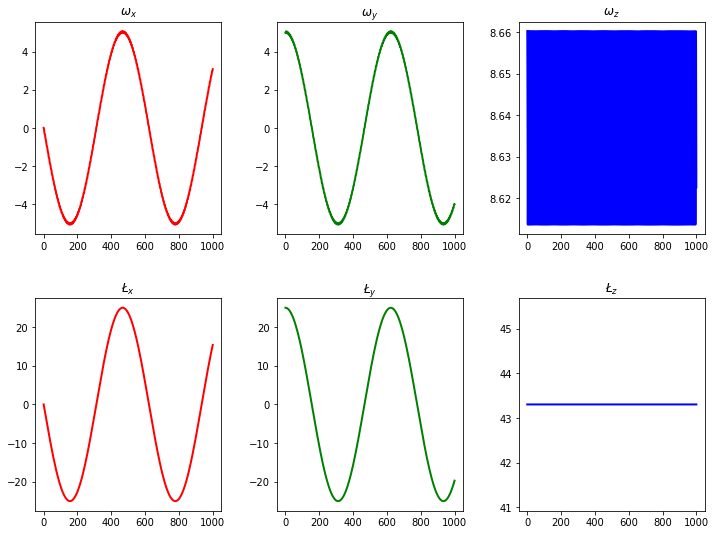

In [12]:
figura = plt.figure(figsize=(12.0,9.0))
figura.subplots_adjust(hspace=0.3, wspace=0.3)

ejes1 = figura.add_subplot(2,3,1)
ejes1.set_title('$\omega_x$')
ejes2 = figura.add_subplot(2,3,2)
ejes2.set_title('$\omega_y$')
ejes3 = figura.add_subplot(2,3,3)
ejes3.set_title('$\omega_z$')

ejes4 = figura.add_subplot(2,3,4)
ejes4.set_title('$\L_x$')
ejes5 = figura.add_subplot(2,3,5)
ejes5.set_title('$\L_y$')
ejes6 = figura.add_subplot(2,3,6)
ejes6.set_title('$\L_z$')

ejes1.plot(t,omegat[:,0],color='red',linewidth='2.0')
ejes2.plot(t,omegat[:,1],color='green',linewidth='2.0')
ejes3.plot(t,omegat[:,2],color='blue',linewidth='2.0')
ejes4.plot(t,Lt[:,0],color='red',linewidth='2.0')
ejes5.plot(t,Lt[:,1],color='green',linewidth='2.0')
ejes6.plot(t,Lt[:,2],color='blue',linewidth='2.0')

(-1.0, 1.0)

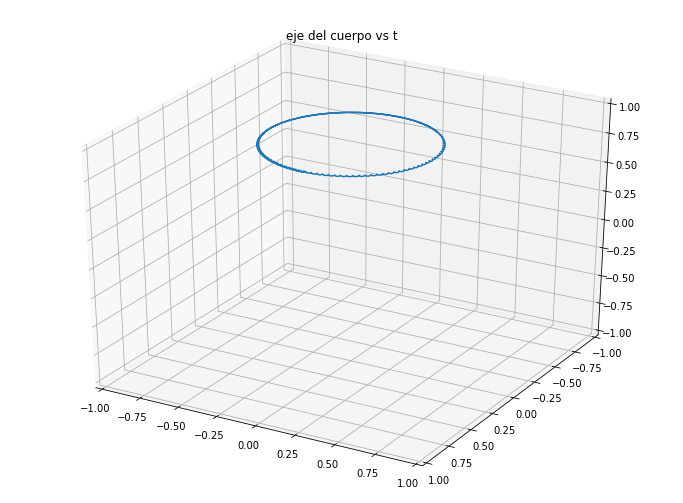

In [13]:
plt.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(12.0,9.0))
ax = fig.gca(projection='3d')

ax.set_title("eje del cuerpo vs t")

ax.plot(eje[:,0],eje[:,1],eje[:,2])
ax.set_xlim(-1.0,1.0)
ax.set_ylim(1.0,-1.0)
ax.set_zlim(-1.0,1.0)

## Trompo simétrico, nutación simple

In [14]:
dt = 0.1
t_max = 400
nsteps = int(t_max/dt)
t = np.linspace(0,t_max,nsteps)

In [15]:
eje0   = np.array([0.0,0.0,1.0]) 

omega0 = np.array([0.0,0.0,0.45]) 

I0 = np.zeros((3,3))
I0[0,0] = 50.0 
I0[1,1] = 50.0 
I0[2,2] = 30.0 

R0 = np.identity(3) 

rotacion = R(-m.pi/5,[1.0,0.0,0.0]) 

omega0 = rotacion @ omega0
eje0   = rotacion @ eje0
I0     = rotacion @ (I0 @ rotacion.T)
L0     = I0 @ omega0

vec0 = vars_to_vector(R0,L0)

fuerza = np.array([0.0,0.0,-0.5])

In [16]:
vec = odeint(dvec, vec0, t, args=(I0,fuerza,eje0))

Lt = np.zeros((nsteps,3))
omegat = np.zeros((nsteps,3))
eje = np.zeros((nsteps,3))
T = np.zeros((nsteps))
for i in range(nsteps):
    omegat[i,:], Lt[i,:], eje[i,:], T[i] = vector_to_tvars(vec[i],I0,eje0)

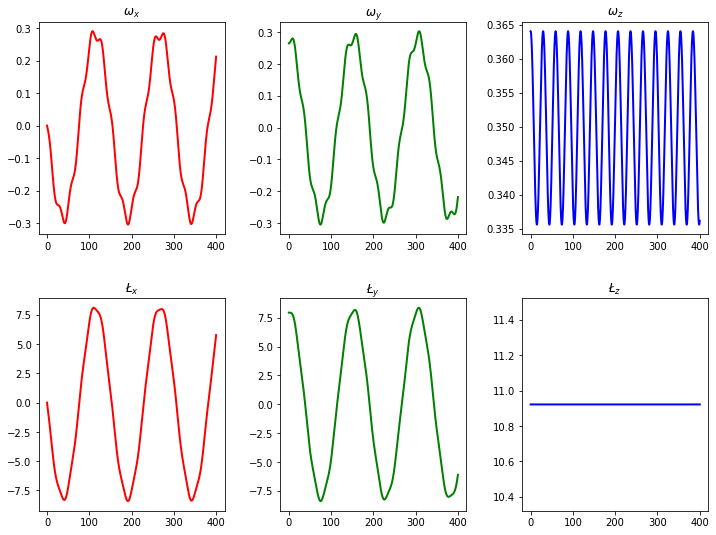

In [17]:
figura = plt.figure(figsize=(12.0,9.0))
figura.subplots_adjust(hspace=0.3, wspace=0.3)

ejes1 = figura.add_subplot(2,3,1)
ejes1.set_title('$\omega_x$')
ejes2 = figura.add_subplot(2,3,2)
ejes2.set_title('$\omega_y$')
ejes3 = figura.add_subplot(2,3,3)
ejes3.set_title('$\omega_z$')

ejes4 = figura.add_subplot(2,3,4)
ejes4.set_title('$\L_x$')
ejes5 = figura.add_subplot(2,3,5)
ejes5.set_title('$\L_y$')
ejes6 = figura.add_subplot(2,3,6)
ejes6.set_title('$\L_z$')

ejes1.plot(t,omegat[:,0],color='red',linewidth='2.0')
ejes2.plot(t,omegat[:,1],color='green',linewidth='2.0')
ejes3.plot(t,omegat[:,2],color='blue',linewidth='2.0')
ejes4.plot(t,Lt[:,0],color='red',linewidth='2.0')
ejes5.plot(t,Lt[:,1],color='green',linewidth='2.0')
ejes6.plot(t,Lt[:,2],color='blue',linewidth='2.0')

(-1.0, 1.0)

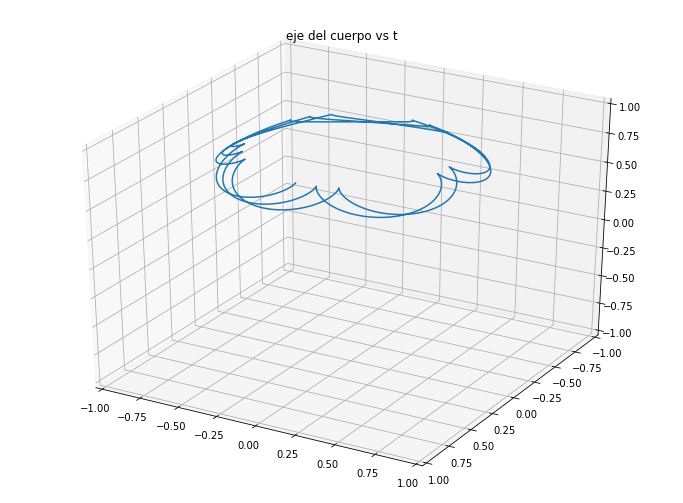

In [18]:
plt.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(12.0,9.0))
ax = fig.gca(projection='3d')

ax.set_title("eje del cuerpo vs t")

ax.plot(eje[:,0],eje[:,1],eje[:,2])
ax.set_xlim(-1.0,1.0)
ax.set_ylim(1.0,-1.0)
ax.set_zlim(-1.0,1.0)

## Trompo simétrico, nutación más compleja

In [19]:
dt = 0.1
t_max = 200
nsteps = int(t_max/dt)
t = np.linspace(0,t_max,nsteps)

In [20]:
eje0   = np.array([0.0,0.0,1.0]) 

omega0 = np.array([0.05,0.0,1.0]) 

I0 = np.zeros((3,3))
I0[0,0] = 50.0 
I0[1,1] = 50.0 
I0[2,2] = 15.0  

R0 = np.identity(3) 

rotacion = R(-m.pi/4,[1.0,0.0,0.0]) 

omega0 = rotacion @ omega0
eje0   = rotacion @ eje0
I0     = rotacion @ (I0 @ rotacion.T)
L0     = I0 @ omega0


vec0 = vars_to_vector(R0,L0)

fuerza = np.array([0.0,0.0,-0.5])


In [21]:
vec = odeint(dvec, vec0, t, args=(I0,fuerza,eje0))

Lt = np.zeros((nsteps,3))
omegat = np.zeros((nsteps,3))
eje = np.zeros((nsteps,3))
T = np.zeros((nsteps))
for i in range(nsteps):
    omegat[i,:], Lt[i,:], eje[i,:], T[i] = vector_to_tvars(vec[i],I0,eje0)

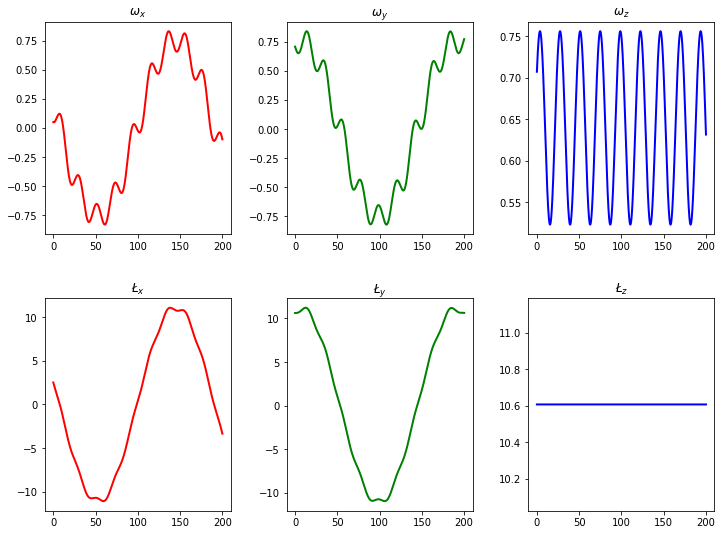

In [22]:
figura = plt.figure(figsize=(12.0,9.0))
figura.subplots_adjust(hspace=0.3, wspace=0.3)

ejes1 = figura.add_subplot(2,3,1)
ejes1.set_title('$\omega_x$')
ejes2 = figura.add_subplot(2,3,2)
ejes2.set_title('$\omega_y$')
ejes3 = figura.add_subplot(2,3,3)
ejes3.set_title('$\omega_z$')

ejes4 = figura.add_subplot(2,3,4)
ejes4.set_title('$\L_x$')
ejes5 = figura.add_subplot(2,3,5)
ejes5.set_title('$\L_y$')
ejes6 = figura.add_subplot(2,3,6)
ejes6.set_title('$\L_z$')

ejes1.plot(t,omegat[:,0],color='red',linewidth='2.0')
ejes2.plot(t,omegat[:,1],color='green',linewidth='2.0')
ejes3.plot(t,omegat[:,2],color='blue',linewidth='2.0')
ejes4.plot(t,Lt[:,0],color='red',linewidth='2.0')
ejes5.plot(t,Lt[:,1],color='green',linewidth='2.0')
ejes6.plot(t,Lt[:,2],color='blue',linewidth='2.0')

(-1.0, 1.0)

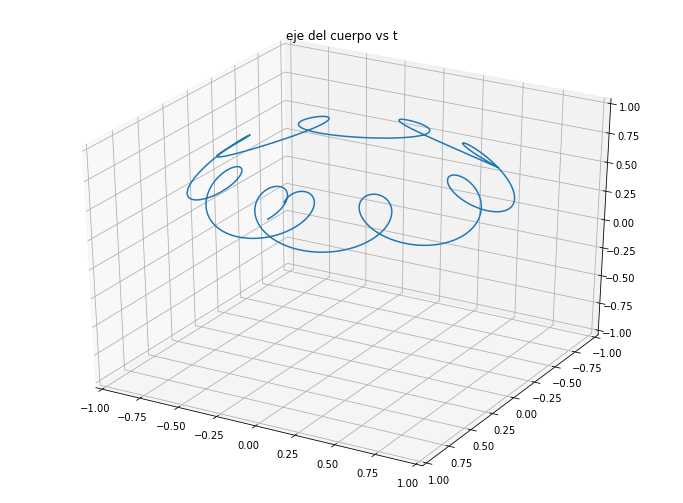

In [23]:
plt.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(12.0,9.0))
ax = fig.gca(projection='3d')

ax.set_title("eje del cuerpo vs t")

ax.plot(eje[:,0],eje[:,1],eje[:,2])
ax.set_xlim(-1.0,1.0)
ax.set_ylim(1.0,-1.0)
ax.set_zlim(-1.0,1.0)

## Inestabilidad del eje intermedio

In [24]:
dt = 0.1
t_max = 100
nsteps = int(t_max/dt)
t = np.linspace(0,t_max,nsteps)

In [25]:
eje0   = np.array([0.0,1.0,0.0]) 
omega0 = np.array([0.001,1.0,0.001]) 
I0 = np.zeros((3,3))
I0[0,0] = 30.0 
I0[1,1] = 20.0 
I0[2,2] = 10.0 

L0 = I0 @ omega0
R0 = np.identity(3)

vec0 = vars_to_vector(R0,L0)

fuerza = np.zeros((3))

In [26]:
vec = odeint(dvec, vec0, t, args=(I0,fuerza,eje0))

Lt = np.zeros((nsteps,3))
omegat = np.zeros((nsteps,3))
eje = np.zeros((nsteps,3))
T = np.zeros((nsteps))
for i in range(nsteps):
    omegat[i,:], Lt[i,:], eje[i,:], T[i] = vector_to_tvars(vec[i],I0,eje0)

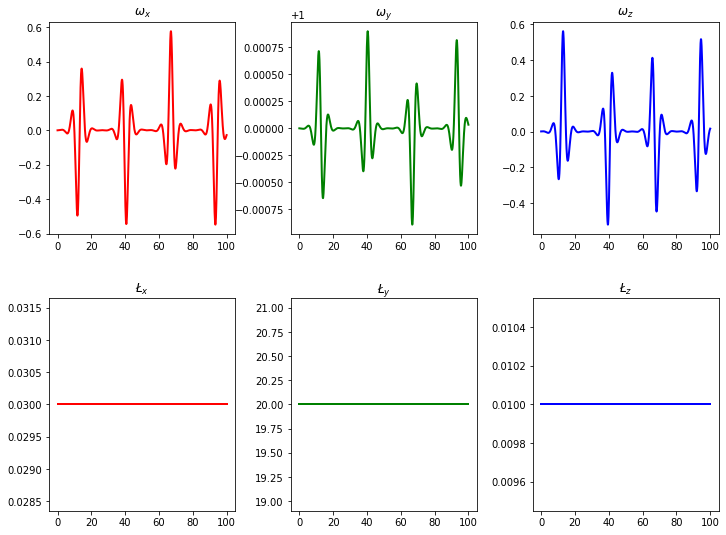

In [27]:
figura = plt.figure(figsize=(12.0,9.0))
figura.subplots_adjust(hspace=0.3, wspace=0.3)

ejes1 = figura.add_subplot(2,3,1)
ejes1.set_title('$\omega_x$')
ejes2 = figura.add_subplot(2,3,2)
ejes2.set_title('$\omega_y$')
ejes3 = figura.add_subplot(2,3,3)
ejes3.set_title('$\omega_z$')

ejes4 = figura.add_subplot(2,3,4)
ejes4.set_title('$\L_x$')
ejes5 = figura.add_subplot(2,3,5)
ejes5.set_title('$\L_y$')
ejes6 = figura.add_subplot(2,3,6)
ejes6.set_title('$\L_z$')

ejes1.plot(t,omegat[:,0],color='red',linewidth='2.0')
ejes2.plot(t,omegat[:,1],color='green',linewidth='2.0')
ejes3.plot(t,omegat[:,2],color='blue',linewidth='2.0')
ejes4.plot(t,Lt[:,0],color='red',linewidth='2.0')
ejes5.plot(t,Lt[:,1],color='green',linewidth='2.0')
ejes6.plot(t,Lt[:,2],color='blue',linewidth='2.0')

(-1.0, 1.0)

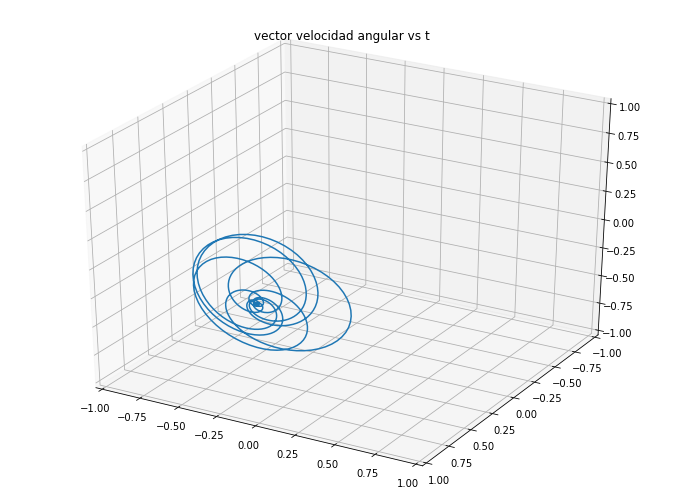

In [28]:
plt.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(12.0,9.0))
ax = fig.gca(projection='3d')

ax.set_title("vector velocidad angular vs t")

ax.plot(omegat[:,0]/np.linalg.norm(omegat,axis=1),
        omegat[:,1]/np.linalg.norm(omegat,axis=1),
        omegat[:,2]/np.linalg.norm(omegat,axis=1))
ax.set_xlim(-1.0,1.0)
ax.set_ylim(1.0,-1.0)
ax.set_zlim(-1.0,1.0)

In [29]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

(-1.0, 1.0)

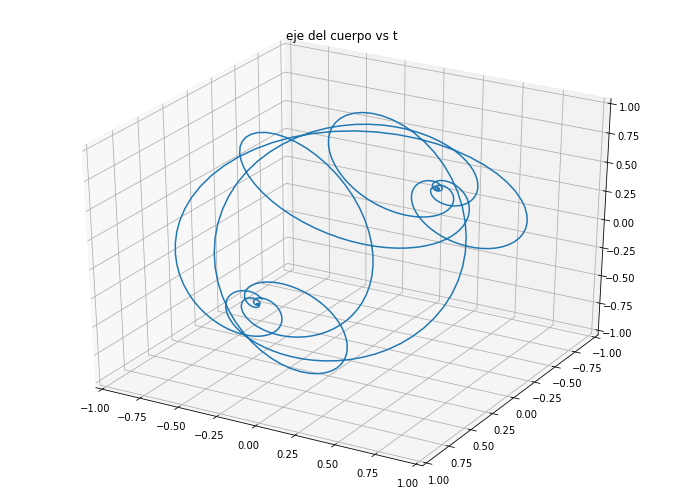

In [30]:
plt.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(12.0,9.0))
ax = fig.gca(projection='3d')

ax.set_title("eje del cuerpo vs t")

ax.plot(eje[:,0],eje[:,1],eje[:,2])
ax.set_xlim(-1.0,1.0)
ax.set_ylim(1.0,-1.0)
ax.set_zlim(-1.0,1.0)